In [5]:
# """Generate colored noise."""

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from numpy import sqrt
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
import scipy.stats
import seaborn as sb
from numpy import sqrt, newaxis
from numpy.fft import irfft, rfftfreq
from numpy.random import normal
from numpy import sum as npsum
import mfdfa
import statsfuncs

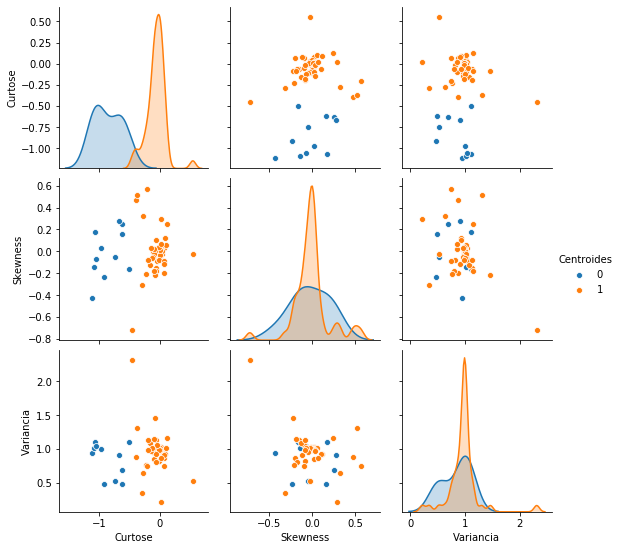

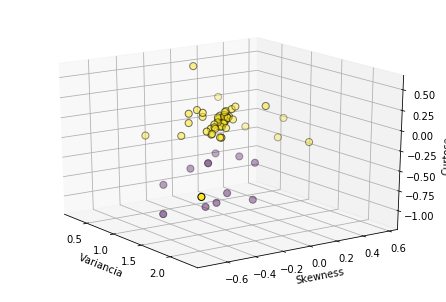

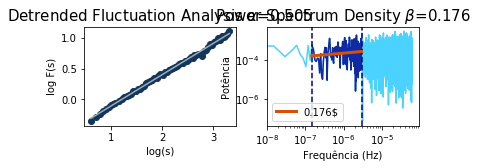

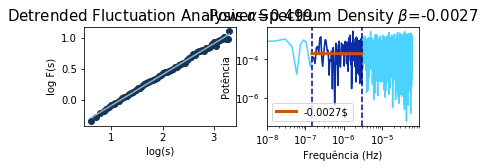

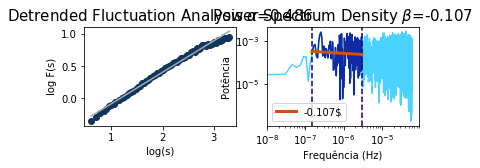

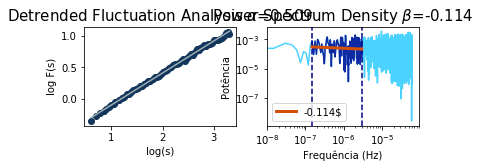

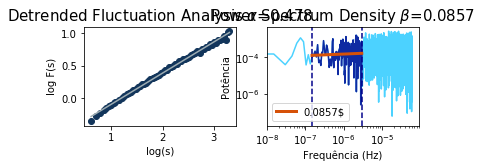

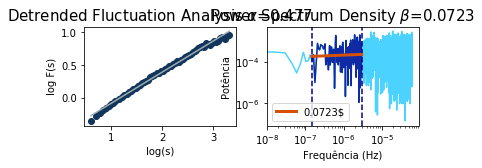

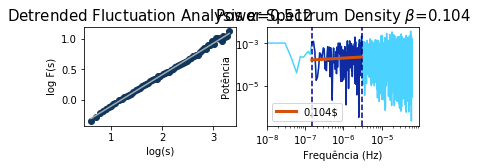

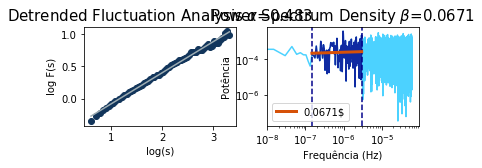

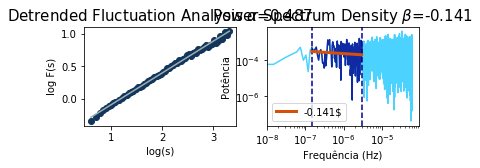

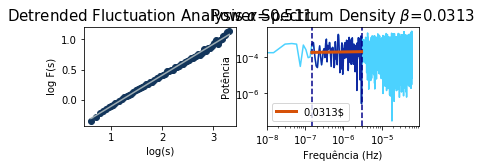

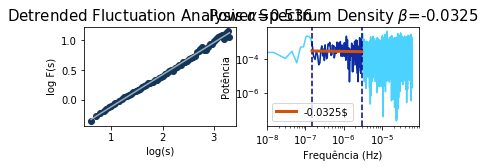

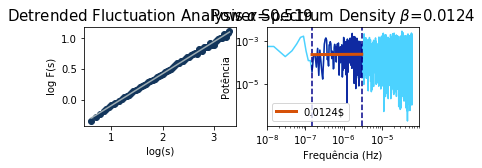

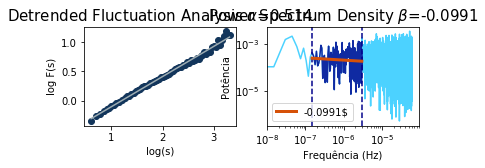

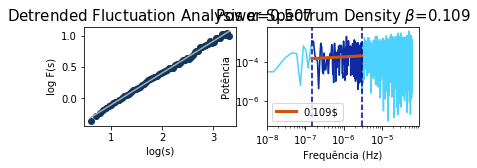

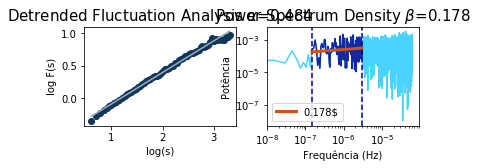

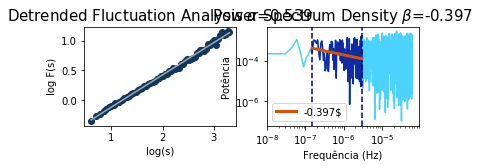

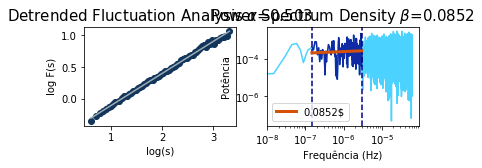

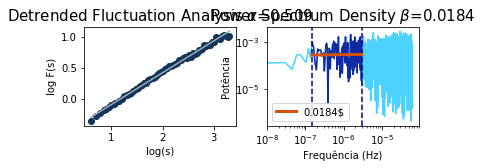

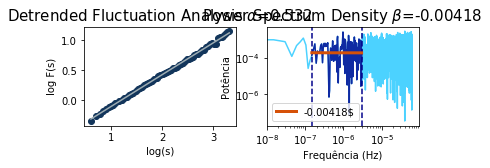

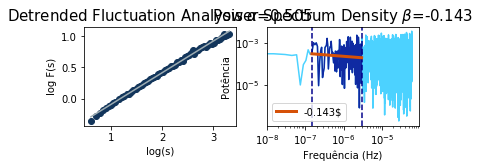

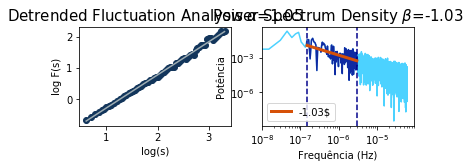

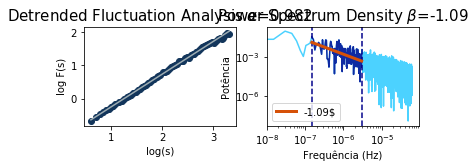

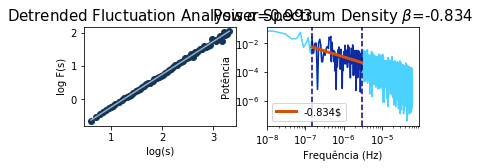

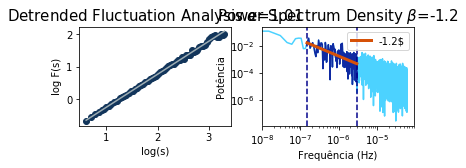

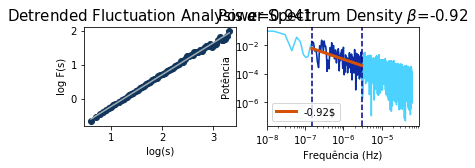

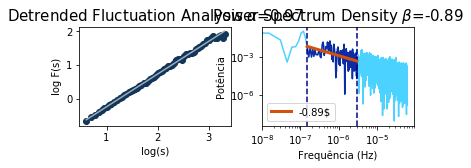

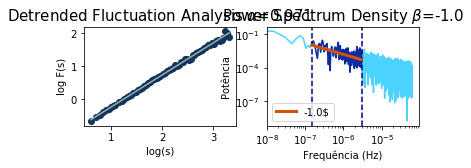

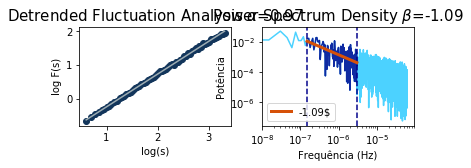

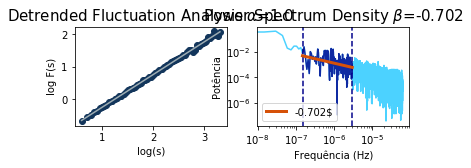

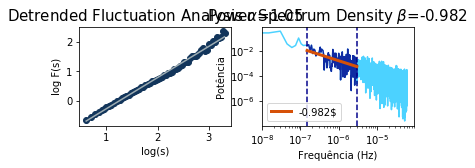

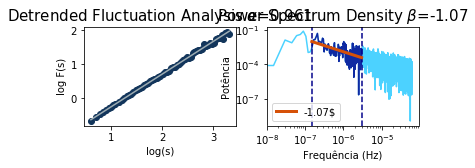

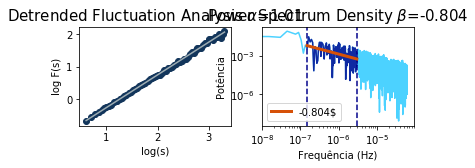

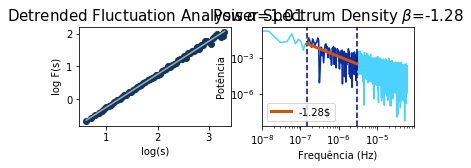

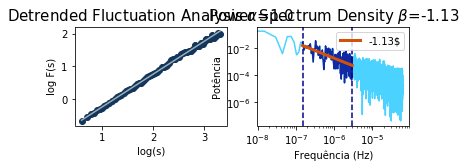

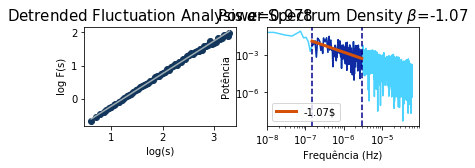

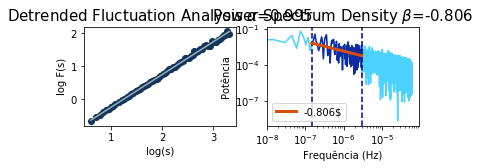

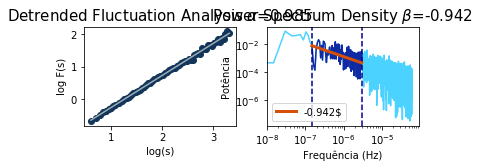

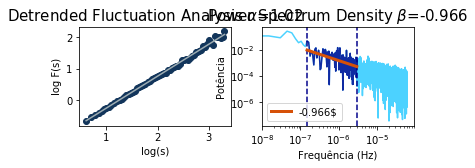

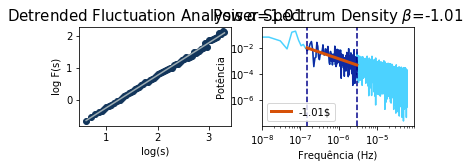

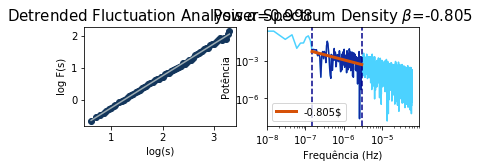

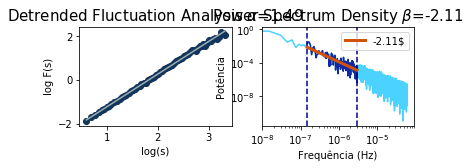

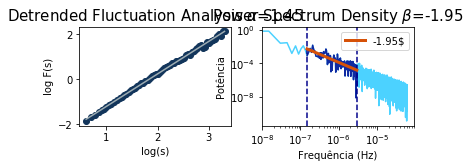

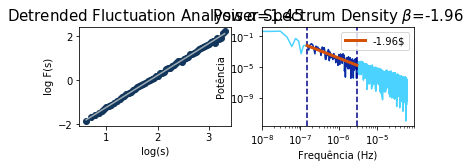

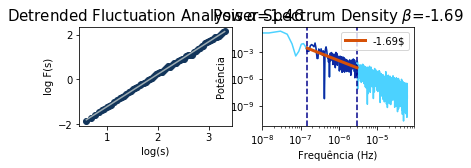

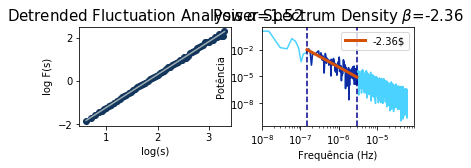

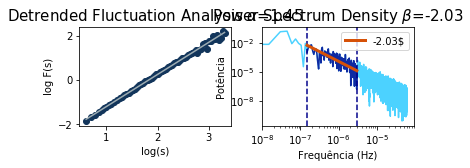

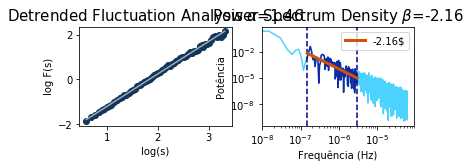

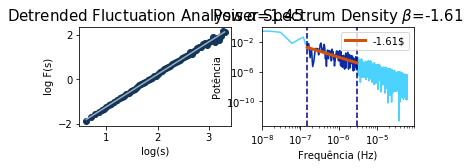

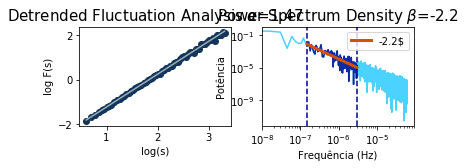

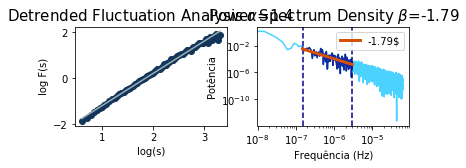

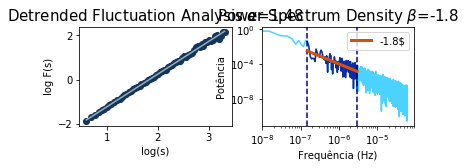

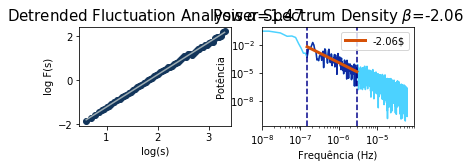

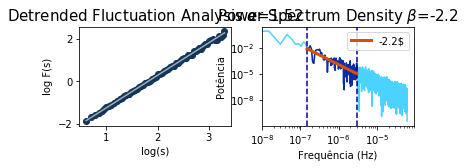

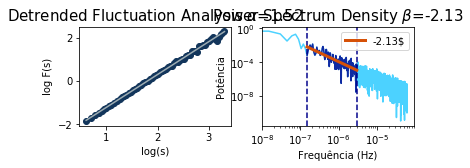

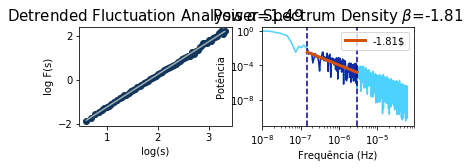

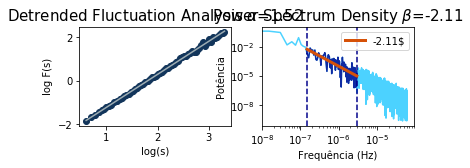

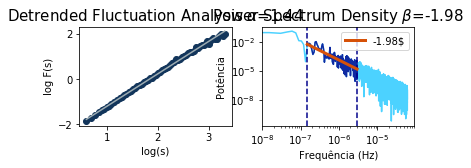

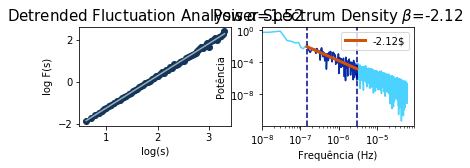

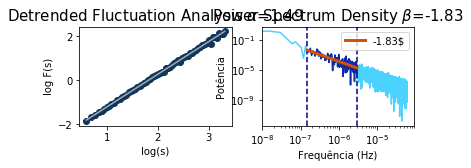

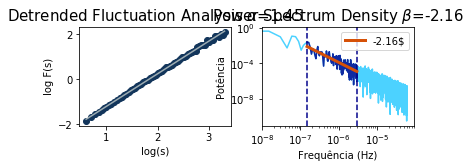

In [8]:
def powerlaw_psd_gaussian(exponent, size, fmin=0):
    """Gaussian (1/f)**beta noise.
    Based on the algorithm in:
    Timmer, J. and Koenig, M.:
    On generating power law noise.
    Astron. Astrophys. 300, 707-710 (1995)
    Normalised to unit variance
    Parameters:
    -----------
    exponent : float
        The power-spectrum of the generated noise is proportional to
        S(f) = (1 / f)**beta
        flicker / pink noise:   exponent beta = 1
        brown noise:            exponent beta = 2
        Furthermore, the autocorrelation decays proportional to lag**-gamma
        with gamma = 1 - beta for 0 < beta < 1.
        There may be finite-size issues for beta close to one.
    shape : int or iterable
        The output has the given shape, and the desired power spectrum in
        the last coordinate. That is, the last dimension is taken as time,
        and all other components are independent.
    fmin : float, optional
        Low-frequency cutoff.
        Default: 0 corresponds to original paper. It is not actually
        zero, but 1/samples.
    Returns
    -------
    out : array
        The samples.
    Examples:
    ---------
    # generate 1/f noise == pink noise == flicker noise
    >>> import colorednoise as cn
    >>> y = cn.powerlaw_psd_gaussian(1, 5)
    """

    # Make sure size is a list so we can iterate it and assign to it.
    try:
        size = list(size)
    except TypeError:
        size = [size]

    # The number of samples in each time series
    samples = size[-1]

    # Calculate Frequencies (we asume a sample rate of one)
    # Use fft functions for real output (-> hermitian spectrum)
    f = rfftfreq(samples)

    # Build scaling factors for all frequencies
    s_scale = f
    fmin = max(fmin, 1. / samples)  # Low frequency cutoff
    ix = npsum(s_scale < fmin)  # Index of the cutoff
    if ix and ix < len(s_scale):
        s_scale[:ix] = s_scale[ix]
    s_scale = s_scale ** (-exponent / 2.)

    # Calculate theoretical output standard deviation from scaling
    w = s_scale[1:].copy()
    w[-1] *= (1 + (samples % 2)) / 2.  # correct f = +-0.5
    sigma = 2 * sqrt(npsum(w ** 2)) / samples

    # Adjust size to generate one Fourier component per frequency
    size[-1] = len(f)

    # Add empty dimension(s) to broadcast s_scale along last
    # dimension of generated random power + phase (below)
    dims_to_add = len(size) - 1
    s_scale = s_scale[(newaxis,) * dims_to_add + (Ellipsis,)]

    # Generate scaled random power + phase
    sr = normal(scale=s_scale, size=size)
    si = normal(scale=s_scale, size=size)

    # If the signal length is even, frequencies +/- 0.5 are equal
    # so the coefficient must be real.
    if not (samples % 2): si[..., -1] = 0

    # Regardless of signal length, the DC component must be real
    si[..., 0] = 0

    # Combine power + corrected phase to Fourier components
    s = sr + 1J * si

    # Transform to real time series & scale to unit variance
    y = irfft(s, n=samples, axis=-1) / sigma

    return y

def plotarSerieColoredNoise():
    i = 0
    j = 0
    title = ""
    corRuido = ""
    
    for i in range(3):
        a = pd.read_csv('Arquivos/RuidoFrequencia' + str(i + 1) + '.csv')
        for j in range(20):
            serie = "Serie " + str(j+1)
            
            if(i == 0):
                title = "White Noise - Serie " + str(j+1)
                corRuido = "lightGray"
            if(i == 1):
                title = "Pink Noise - Serie " + str(j+1)
                corRuido = "pink"
            if(i == 2):
                title = "Red Noise - Serie " + str(j+1)
                corRuido = "red"
            
            plt.plot(a[serie], color = corRuido)
            plt.title(title)
            plt.xlabel("Quantidade de Elementos")
            plt.ylabel("Amplitude")
            plt.show()
    
def gerarSerieColoredNoise():
    
    n = 8192
    res = n / 12
    i = 0
    j = 0
    df = []
    
    for i in range(3):
        for j in range(20):
            df.append(pd.DataFrame(powerlaw_psd_gaussian(i, n), columns=['Serie ' + str(j + 1)]))

        #Concatena os ruídos da familia gerada randomicamente, como também as normalizadas
        a = pd.concat([df[0], df[1], df[2], df[3], df[4], df[5], df[6], df[7], df[8], df[9], df[10], df[11], df[12], df[13], df[14], df[15], df[16], df[17], df[18], df[19]], axis=1, join='inner')

        # Armazena os ruídos concatenadas em arquivo .csv
        a.to_csv('Arquivos/RuidoFrequencia' + str(i + 1) + '.csv', index=False, header=True)
        j = 0
        df.clear()

def plotarHistograma():
    #Gerando Histograma dos ruídos
    i = 0
    j = 0
    n = 8192
    title = ""
    corRuido = ""

    for i in range(3):
        dado = pd.read_csv('Arquivos/RuidoFrequencia' + str(i + 1) + '.csv')
        for j in range(20):
            
            if(i == 0):
                title = "White Noise - Serie " + str(j+1)
                corRuido = "lightGray"
            if(i == 1):
                title = "Pink Noise - Serie " + str(j+1)
                corRuido = "pink"
            if(i == 2):
                title = "Red Noise - Serie " + str(j+1)
                corRuido = "red"
            
            dado.hist(column='Serie ' + str(j+1), bins=int(n/10), alpha=0.6, color=corRuido)
            plt.title(title)
            plt.savefig('Histogramas/Serie' + str(j+1) + '_Ruido' + str(i+1) + '.png')
            plt.show()
            plt.close()
        j = 0

def quatroMomentos():
    # Calcula os momentos estatisticos das series e armazena-as em arquivos .csv
    i = 0
    c = []
    v = []
    m = []
    s = []

    for i in range(3):
        dado = pd.read_csv('Arquivos/RuidoFrequencia' + str(i + 1) + '.csv')

        # Skewness
        s.append(pd.DataFrame(dado.skew(axis=0, skipna=True), columns=['Skewness']))

        # Curtose
        curtose = scipy.stats.kurtosis(dado)
        c.append(pd.DataFrame(curtose, columns=['Curtose']))

        # Variancia
        v.append(pd.DataFrame(dado.var(axis=0, skipna=True), columns=['Variancia']))

        # Media
        m.append(pd.DataFrame(dado.mean(axis=0, skipna=True), columns=['Media']))  

    skew = pd.concat([s[0], s[1], s[2]], join='inner')
    skew.to_csv('Arquivos/Quatro Momentos Estatisticos/Skewness_ruidos.csv', index= False,header=True)

    curt = pd.concat([c[0], c[1], c[2]], join='inner')
    curt.to_csv('Arquivos/Quatro Momentos Estatisticos/Curtose_ruidos.csv', index= False, header=True)

    var = pd.concat([v[0], v[1], v[2]], join='inner')
    var.to_csv('Arquivos/Quatro Momentos Estatisticos/Variancia_ruidos.csv', index= False,header=True)

    med = pd.concat([m[0], m[1], m[2]], join='inner')
    med.to_csv('Arquivos/Quatro Momentos Estatisticos/Media_ruidos.csv', index= False, header=True)

    s.clear()
    c.clear()
    v.clear()
    m.clear()

def Kmeans():
    
    #Importa os dados da Curtose, Skewness e Variancia

    curt = pd.read_csv('Arquivos/Quatro Momentos Estatisticos/Curtose_ruidos.csv')
    skew = pd.read_csv('Arquivos/Quatro Momentos Estatisticos/Skewness_ruidos.csv')
    var = pd.read_csv('Arquivos/Quatro Momentos Estatisticos/Variancia_ruidos.csv')
    
    #Adiciona os dados dentro de um mesmo dataFrame

    result = pd.DataFrame(curt, columns=['Curtose'])
    result['Skewness'] = skew
    result['Variancia'] = var
    
    #Configura o Kmeans com dois centróides
    kmeans = KMeans(n_clusters = 2, random_state=0)
     
    #Executa o algoritmo para fazer o ajuste dos pontos através dos centróides
    kmeans.fit(result)    
    
    #Adiciona uma nova coluna no DataFrame com os centróides que cada conjunto de pontos está associado
    result['Centroides'] = kmeans.labels_

    #Plota um gráfico mostrando a distribuição dos pontos (qual centroide cada conjunto pertence)
    sb.pairplot(result,'Centroides')
    
    #Plota um gráfico 3D mostrando a distribuição dos pontos (qual centroide cada conjunto pertence)

    fig1 = plt.figure()
    ax = fig1.add_subplot(111, projection='3d')
    ax = Axes3D(fig1, rect=[0, 0, 1, 1], elev=20, azim=-35)
    ax.scatter(result['Variancia'],
               result['Skewness'],
               result['Curtose'],
               c=result['Centroides'],
               edgecolor='black', s=50)
    ax.set_xlabel('Variancia')
    ax.set_ylabel('Skewness')
    ax.set_zlabel('Curtose')
    plt.show()
    
def psdDfa():
    
    for i in range(3):
        dado = pd.read_csv('Arquivos/RuidoFrequencia' + str(i + 1) + '.csv')
        for j in range(20):
            serie = 'Serie ' + str(j+1)
            alfa,xdfa,ydfa, reta = statsfuncs.dfa1d(dado[serie],1)
            freqs, power, xdata, ydata, amp, index, powerlaw, INICIO, FIM = statsfuncs.psd(dado[serie])       
   
            #Plot e cálculo do DFA
            ax2 = plt.subplot(223)
            ax2.set_title(r"Detrended Fluctuation Analysis $\alpha$={0:.3}".format(alfa), fontsize=15)
            ax2.plot(xdfa,ydfa, marker='o', linestyle='', color="#12355B", label="{0:.3}".format(alfa))
            ax2.plot(xdfa, reta, color="#9DACB2")
            #Plot e cáculo do PSD
            ax3 = plt.subplot(224)
            ax3.set_title(r"Power Spectrum Density $\beta$={0:.3}".format(index), fontsize=15)
            ax3.set_yscale('log')
            ax3.set_xscale('log')
            ax3.plot(freqs, power, '-', color = 'deepskyblue', alpha = 0.7)
            ax3.plot(xdata, ydata, color = "darkblue", alpha = 0.8)
            ax3.axvline(freqs[INICIO], color = "darkblue", linestyle = '--')
            ax3.axvline(freqs[FIM], color = "darkblue", linestyle = '--')    
            ax3.plot(xdata, powerlaw(xdata, amp, index),color="#D65108", linestyle='-', linewidth = 3, label = '{0:.3}$'.format(index)) 
            ax2.set_xlabel("log(s)")
            ax2.set_ylabel("log F(s)")
            ax3.set_xlabel("Frequência (Hz)")
            ax3.set_ylabel("Potência")
            ax3.legend()
            plt.savefig('PSD-DFA/Serie' + str(j+1) + '_Ruido' + str(i+1) +  '.png')
            plt.show()
        
def main():
    #gerarSerieColoredNoise()
    #plotarSerieColoredNoise()
    #plotarHistograma()
    quatroMomentos()
    Kmeans()
    psdDfa()
                           
main()